In [ ]:
!pip install rasterio xgboost lightgbm optuna shap statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.3 MB/s eta 0:00:00


#1. Dataset 로딩

QGIS 상에서 align raster를 통해 좌표값 위치 정렬한 후 colab에 올리면 픽셀끼리 어긋나지 않음


사용된 데이터셋

- 1) DEM

  표고 데이터를 TIN 보간법을 통해 래스터화


- 2) PTF

  단층거리

- 3) 강수량

  서울시 과거 기간의 평균 강수량을 IDW 보간으로 래스터화

- 4) 경사

  DEM 래스터 데이터에 대해, 유한차분법을 통해 경사 계산

- 5) 도로거리

  각 지점에서 측정한 도로까지의 최단거리

- 6) 지하수

  IDW 보간으로, 관측소별 지하수 사용량에 로그 씌우고 래스터화

- 7 : 하천용도

  하천인지의 여부 마스킹. 하천이면 1, 아니면 0.

In [ ]:
import rasterio
import numpy as np

# 1) 파일 경로들을 리스트에 담기
tif_paths = [
    '/content/DEM.tif',
    '/content/PTF.tif',
    '/content/강수량.tif',
    '/content/경사.tif',
    '/content/도로거리.tif',
    '/content/지하수.tif',
    '/content/하천용도.tif',
]

channel_names = [
    'DEM',
    'PTF',
    'Precipitation',
    'Slope',
    'Dist_to_Road',
    'Groundwater_Level',
    'River_Usage'
]

arrays = []
with rasterio.open(tif_paths[0]) as src0:
    meta = src0.meta.copy()      # 전체 메타데이터 복사 (dtype, count, crs, transform…)
    transform = src0.transform   # Affine
    crs = src0.crs               # CRS 객체

# 나머지 파일도 읽어서 배열만 쌓기
for path in tif_paths:
    with rasterio.open(path) as src:
        arrays.append(src.read(1))

stacked = np.stack(arrays, axis=0)
print("stacked.shape:\n", stacked.shape)
print("transform:\n", transform)
print("CRS:\n", crs)

stacked.shape:
 (7, 1513, 1850)
transform:
 | 20.00, 0.00, 179220.00|
| 0.00,-20.00, 566840.00|
| 0.00, 0.00, 1.00|
CRS:
 EPSG:5186


#2. 데이터 정렬 검증

각 tiff에 대해 transform matrix 동일하고, 픽셀 몇개가 같은 위치로 매핑된다면 완벽히 정렬된거임!

In [ ]:
import rasterio
from rasterio.transform import xy
import numpy as np

# 1) 각 래스터의 메타데이터(transform, shape) 수집
transforms = []
shapes = []
for path in tif_paths:
    with rasterio.open(path) as src:
        transforms.append(src.transform)
        shapes.append((src.height, src.width))

# 2) 모두 같은 transform / shape 인지 확인
all_same_transform = all(t == transforms[0] for t in transforms)
all_same_shape     = all(s == shapes[0]     for s in shapes)

print("Transforms identical? ", all_same_transform)
print("Shapes identical?     ", all_same_shape, "→", shapes[0])

# (만약 모두 True 라면, 모든 픽셀 인덱스에 대해 world-coordinate 대응이 동일합니다)

# 3) 샘플 인덱스 몇 개 뽑아서 world coords 비교
#    rasterio.transform.xy(transform, row, col) 을 쓰면 쉽게 얻을 수 있어요.
sample_pixels = [
    (0, 0),
    (shapes[0][0]//2, shapes[0][1]//2),
    (shapes[0][0]-1, shapes[0][1]-1),
]

for row, col in sample_pixels:
    coords = [ xy(tf, row, col) for tf in transforms ]
    # coords 는 [(x1,y1),(x2,y2),…]
    all_equal = all(np.allclose(coords[0], c) for c in coords[1:])
    print(f"Pixel ({row},{col}) → coords: {coords} |\n all equal? {all_equal}")


Transforms identical?  True
Shapes identical?      True → (1513, 1850)
Pixel (0,0) → coords: [(np.float64(179230.0), np.float64(566830.0)), (np.float64(179230.0), np.float64(566830.0)), (np.float64(179230.0), np.float64(566830.0)), (np.float64(179230.0), np.float64(566830.0)), (np.float64(179230.0), np.float64(566830.0)), (np.float64(179230.0), np.float64(566830.0)), (np.float64(179230.0), np.float64(566830.0))] |
 all equal? True
Pixel (756,925) → coords: [(np.float64(197730.0), np.float64(551710.0)), (np.float64(197730.0), np.float64(551710.0)), (np.float64(197730.0), np.float64(551710.0)), (np.float64(197730.0), np.float64(551710.0)), (np.float64(197730.0), np.float64(551710.0)), (np.float64(197730.0), np.float64(551710.0)), (np.float64(197730.0), np.float64(551710.0))] |
 all equal? True
Pixel (1512,1849) → coords: [(np.float64(216210.0), np.float64(536590.0)), (np.float64(216210.0), np.float64(536590.0)), (np.float64(216210.0), np.float64(536590.0)), (np.float64(216210.0), np.floa

#3. GeoDataFrame 형태로 데이터셋 병합

## 1) Tiff 여러개를 GeoDataFrame 형태로 변환 & 저장

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from rasterio.transform import xy

# — 준비된 변수 —
# stacked: np.ndarray, shape = (7, height, width)
# channel_names: list of str, 길이 7
# transform: Affine (from src0.transform)
# crs: CRS object
nodata = -9999

# 1) 모든 채널에서 유효한(=NoData가 아닌) 픽셀만 골라내는 마스크
#    stacked != nodata → (7, h, w) bool 배열 → all(axis=0) → (h, w)
valid_mask = np.all(stacked != nodata, axis=0)

# 2) valid 픽셀의 행(row), 열(col) 인덱스 추출
rows, cols = np.where(valid_mask)

# 3) 행/열 → 실제 좌표(x,y) 계산
#    rasterio.transform.xy(transform, row, col) 이용
xs, ys = xy(transform, rows, cols)  # 각각 길이 N 리스트

# 4) 각 채널의 값 추출
data = {
    'geometry': [Point(x, y) for x, y in zip(xs, ys)]
}
for band_index, name in enumerate(channel_names):
    # stacked[band_index, rows, cols] 은 1D 배열 (길이 N)
    data[name] = stacked[band_index, rows, cols]

# 5) pandas DataFrame → GeoDataFrame 변환
df = pd.DataFrame(data)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs)

# 확인
print(f"GeoDataFrame rows: {len(gdf)}")
print(gdf.head())


GeoDataFrame rows: 1499619
                geometry         DEM          PTF  Precipitation      Slope  \
0  POINT (200870 566070)  633.483887  1659.517822    1479.908325  28.711983   
1  POINT (200890 566070)  626.243774  1679.196411    1480.176025  28.711948   
2  POINT (200910 566070)  619.003662  1699.176270    1480.442871  28.711990   
3  POINT (200930 566070)  611.763489  1699.176270    1480.709106  28.711990   
4  POINT (200950 566070)  604.523376  1719.447754    1480.974487  28.711948   

   Dist_to_Road  Groundwater_Level  River_Usage  
0   2318.361572           5.250682          0.0  
1   2322.068115           5.251057          0.0  
2   2325.940674           5.251401          0.0  
3   2329.978516           5.251718          0.0  
4   2334.180664           5.252008          0.0  


In [ ]:
# 1) geometry를 x, y 컬럼으로 분리
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# 2) CSV에 포함할 컬럼 리스트 결정
#    예: channel_names + ['x','y']
cols = channel_names + ['x', 'y']

# 3) CSV로 저장 (geometry는 제외)
out_csv = '/content/raster_channels.csv'
gdf[cols].to_csv(out_csv, index=False)

print(f"Saved CSV to: {out_csv}")

Saved CSV to: /content/raster_channels.csv


## 2) Label 생성

Label crawling 후 기존 csv 파일에 병합

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import time

# STEP 1: Fetch sinkhole accident data from API
data = []
for page in range(1, 11):  # 10 pages × 10 rows = 100 records
    url = (
        "http://apis.data.go.kr/1611000/undergroundsafetyinfo/getSubsidenceList"
        "?serviceKey=QF9%2B70U2NOIDcShAh2um70tX83cQlgeyi4RWZmBzy%2BKWYa9JH51gEuy4ZnmfLjEqK74KJW31ETxXibZOQNvYqw%3D%3D"
        f"&pageNo={page}"
        "&numOfRows=10"
        "&type=xml"
        "&sagoDateFrom=20000101"
        "&sagoDateTo=20191231"
    )
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "xml")

    items = soup.find_all("item")
    for item in items:
        data.append({
            "사고번호": item.find("sagoNo").text if item.find("sagoNo") else None,
            "시도": item.find("sido").text if item.find("sido") else None,
            "시군구": item.find("sigungu").text if item.find("sigungu") else None,
            "사고일자": item.find("sagoDate").text if item.find("sagoDate") else None,
            "사고내용": item.find("sagoDetail").text if item.find("sagoDetail") else None,
            "내부번호": item.find("no").text if item.find("no") else None,
        })

df = pd.DataFrame(data)
print("✅ 사고 건수:", len(df))
print(df.head())

# STEP 2: Geocode locations using Nominatim
geolocator = Nominatim(user_agent="sinkhole_mapper")
df["lat"] = None
df["lon"] = None

for i, row in df.iterrows():
    try:
        location = geolocator.geocode(f"{row['시도']} {row['시군구']}")
        if location:
            df.at[i, "lat"] = location.latitude
            df.at[i, "lon"] = location.longitude
        time.sleep(1.1)  # to avoid being rate-limited
    except:
        continue

df = df.dropna(subset=["lat", "lon"])

# STEP 3: Convert to GeoDataFrame
subsidence_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
)

# STEP 4: Reproject to match raster grid CRS (usually EPSG:5186)
subsidence_gdf = subsidence_gdf.to_crs("EPSG:5186")

# STEP 5: Inject real sinkhole labels into raster grid (gdf)
# This assumes `gdf` already exists and contains your raster feature points
gdf = gdf.to_crs("EPSG:5186")  # just in case
gdf["label"] = gdf.geometry.apply(
    lambda p: subsidence_gdf.distance(p).min() < 100  # meters
).astype(int)

print("✅ Real sinkhole labels injected.")
print(gdf["label"].value_counts())

✅ 사고 건수: 100
       사고번호     시도   시군구      사고일자  \
0  20180001  서울특별시   강남구  20180301   
1  20180002  서울특별시   송파구  20180304   
2  20180003  서울특별시   구로구  20180311   
3  20180004  서울특별시  영등포구  20180313   
4  20180005  서울특별시  영등포구  20180327   

                                               사고내용 내부번호  
0       열수송관(D600mm) 노후 손상으로 함몰 발생\n(굴착복구 미흡분야로 관리)    1  
1   상수관(？300mm)에서 분기된 소화전 연결관(？100mm) 동파로 누수되어 함몰발생    2  
2                   KT 통신맨홀 슬라브 파손\n(굴착복구 미흡분야로 관리)    3  
3                          하수관로(D450㎜) 노후？파손으로 토사유실    4  
4  인근 공사차량(레미콘차) 중량에 의한 노후 하수박스 상판파손(하수박스 1946년 부설)    5  
✅ Real sinkhole labels injected.
label
0    1498676
1        943
Name: count, dtype: int64


## 3) Train / Test split

In [ ]:
# 3) 80/20 Train/Test split (stratify로 비율 유지)
from sklearn.model_selection import train_test_split
train_gdf, test_gdf = train_test_split(
    gdf,
    test_size=0.2,
    stratify=gdf['label'],
    random_state=42
)

In [ ]:
# STEP 1: Separate positive and negative samples
gdf_pos = gdf[gdf["label"] == 1]
gdf_neg = gdf[gdf["label"] == 0]

# STEP 2: Undersample negatives to balance the dataset
# Here we keep 3x more negatives than positives (adjust as needed)
gdf_neg_sampled = gdf_neg.sample(n=len(gdf_pos)*3, random_state=42)

# STEP 3: Combine into a balanced GeoDataFrame
gdf_balanced = pd.concat([gdf_pos, gdf_neg_sampled]).sample(frac=1, random_state=42)

# STEP 4: Train/Test Split (stratified)
from sklearn.model_selection import train_test_split

train_gdf, test_gdf = train_test_split(
    gdf_balanced,
    test_size=0.2,
    stratify=gdf_balanced['label'],
    random_state=42
)

In [ ]:
train_gdf[:10]

,geometry,DEM,PTF,Precipitation,Slope,Dist_to_Road,Groundwater_Level,River_Usage,x,y,label
18948,POINT (206610 564910),296.365082,1236.931641,1472.084229,12.938709,84.852814,5.631390,0.0,206610.0,564910.0,0
1277431,POINT (209790 542750),11.915404,419.999969,1369.818481,2.581737,44.721359,4.832281,1.0,209790.0,542750.0,0
1315605,POINT (195730 542170),38.371174,933.380981,1352.777588,1.835762,20.000000,5.163996,0.0,195730.0,542170.0,1
687302,POINT (212910 550610),44.845745,2971.060303,1465.696777,5.704900,20.000000,4.735531,0.0,212910.0,550610.0,0
1213218,POINT (196350 543650),101.426926,1894.043335,1340.161255,10.353096,72.111023,4.804058,0.0,196350.0,543650.0,0
953403,POINT (203150 547250),22.870758,3033.710693,1355.086670,3.332088,44.721359,4.297399,0.0,203150.0,547250.0,0
1433009,POINT (191250 540010),35.002228,2058.008789,1342.744873,4.192463,40.000000,4.892873,0.0,191250.0,540010.0,0
968540,POINT (191930 547030),9.505438,3877.434814,1328.365967,1.045860,20.000000,4.456810,0.0,191930.0,547030.0,0
447668,POINT (206210 553730),14.634655,0.000000,1426.096802,0.186883,121.655258,4.245111,0.0,206210.0,553730.0,0
536552,POINT (183610 552390),10.512094,2850.473633,1358.328857,1.372802,0.000000,5.223626,0.0,183610.0,552390.0,0


#4. 모델 정의 / 학습 / 사후분석

## 1) 전체 학습 & eval 코드

- Optuna 활용 안했음

- 정제된 피쳐 사용 예정이므로 다중공선성 굳이 확인 안했음

In [ ]:
list(gdf.columns[1:-3])

['DEM',
 'PTF',
 'Precipitation',
 'Slope',
 'Dist_to_Road',
 'Groundwater_Level',
 'River_Usage']

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# 데이터 로딩

X_train = train_gdf[list(gdf.columns[1:-3])][:2000]
y_train = train_gdf['label'][:2000]
X_test  = test_gdf[list(gdf.columns[1:-3])][:2000]
y_test  = test_gdf['label'][:2000]

print(X_train.columns)

# 최적 모델 학습
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost':      xgb.XGBClassifier(),
    'LightGBM':     lgb.LGBMClassifier()
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    proba = clf.predict_proba(X_test)[:,1]

    # 5. 성능 평가
    acc = accuracy_score(y_test, preds)
    prec= precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    spec= tn / (tn+fp)
    f1  = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, proba)
    print(f"\n[{name}] Accuracy={acc:.3f}, Precision={prec:.3f}, Recall={rec:.3f}, Specificity={spec:.3f}, F1={f1:.3f}, AUC={auc:.3f}\n")

Index(['DEM', 'PTF', 'Precipitation', 'Slope', 'Dist_to_Road',
       'Groundwater_Level', 'River_Usage'],
      dtype='object')

[RandomForest] Accuracy=0.996, Precision=1.000, Recall=0.984, Specificity=1.000, F1=0.992, AUC=1.000


[XGBoost] Accuracy=0.992, Precision=0.974, Recall=0.995, Specificity=0.991, F1=0.984, AUC=1.000

[LightGBM] [Info] Number of positive: 496, number of negative: 1504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248000 -> initscore=-1.109308
[LightGBM] [Info] Start training from score -1.109308

[LightGBM] Accuracy=0.995, Precision=0.984, Recall=0.995, Specificity=0.995, F1=0.989, AUC=1.000



## 2) SHAP 분석 4가지

- Local SHAP importance

- Global SHAP importance

- Dependencg Plot

- Susceptibility map

In [ ]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt

# — 준비된 변수 —
X_train = train_gdf[gdf.columns[1:-3]][:2000]
y_train = train_gdf['label'][:2000]
X_test  = test_gdf[gdf.columns[1:-3]][:2000]
y_test  = test_gdf['label'][:2000]

# 1) RF 모델 학습 (Hyperparameters는 Optuna 튜닝 결과 사용)
rf = RandomForestClassifier(
    n_estimators=822,
    min_samples_split=4,
    max_depth=13,
    min_samples_leaf=4,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=822, random_state=42)

In [ ]:
# explainer, rf, X_test는 앞서 학습된 RandomForest와 test 입력 데이터
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap_values_class1 = shap_values[:,:,1]
shap_values_class1.shape

(755, 7)

### Local SHAP Importance

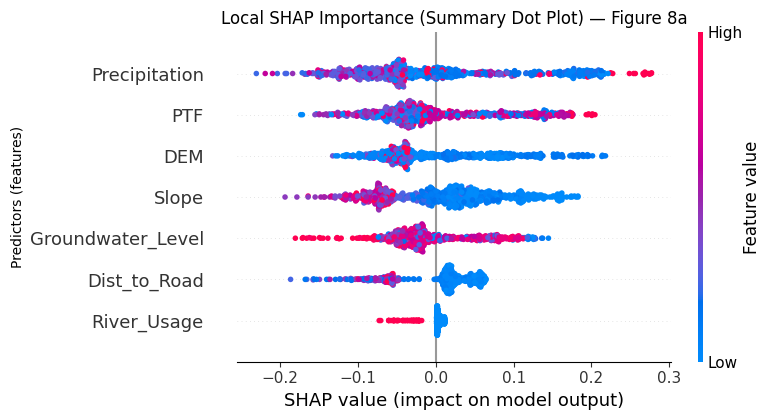

In [ ]:
# 2) Local SHAP Importance 시각화 (Figure 8a 재현)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_class1,          # SHAP 값 배열, shape = (n_samples, n_features)
    X_test,               # 입력 피처 값 DataFrame
    plot_type="dot",      # 점(dot) 분포형
    max_display=20,       # 상위 20개 피처만 표시
    show=False,            # plt.show()는 다음에 호출
    color="blue"
)

plt.title("Local SHAP Importance (Summary Dot Plot) — Figure 8a")
plt.xlabel("SHAP value (impact on model output)")
plt.ylabel("Predictors (features)")
plt.tight_layout()
plt.show()


### Global SHAP Importance

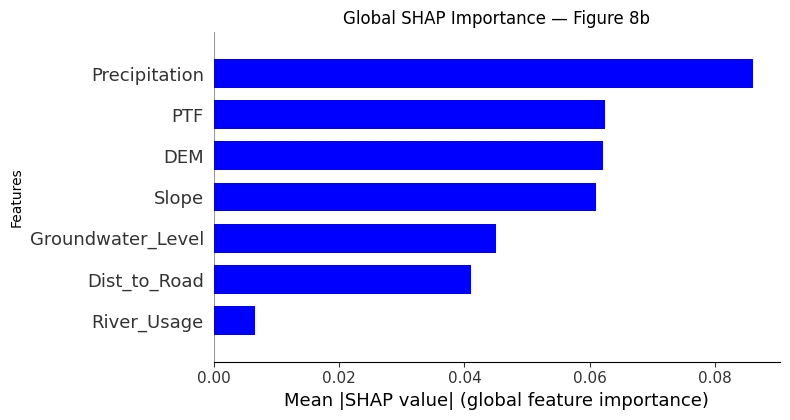

In [ ]:
import matplotlib.pyplot as plt

# — shap_vals_class1, X_test 는 이미 준비된 상태 —
# shap_vals_class1.shape == (n_samples, n_features)
# X_test.shape               == (n_samples, n_features)

# Global SHAP Importance (Figure 8b 재현)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_class1,     # Local에서 추출한 클래스 1 SHAP 값
    X_test,               # 같은 형태의 DataFrame
    plot_type="bar",      # bar 형태로 평균 절대값 표시
    max_display=20,       # 상위 20개 피처
    color="blue",         # 막대 색상 지정 (원하시는 색으로 변경 가능)
    show=False            # plt.show()는 아래에서 호출
)
plt.title("Global SHAP Importance — Figure 8b")
plt.xlabel("Mean |SHAP value| (global feature importance)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### Dependency Plot

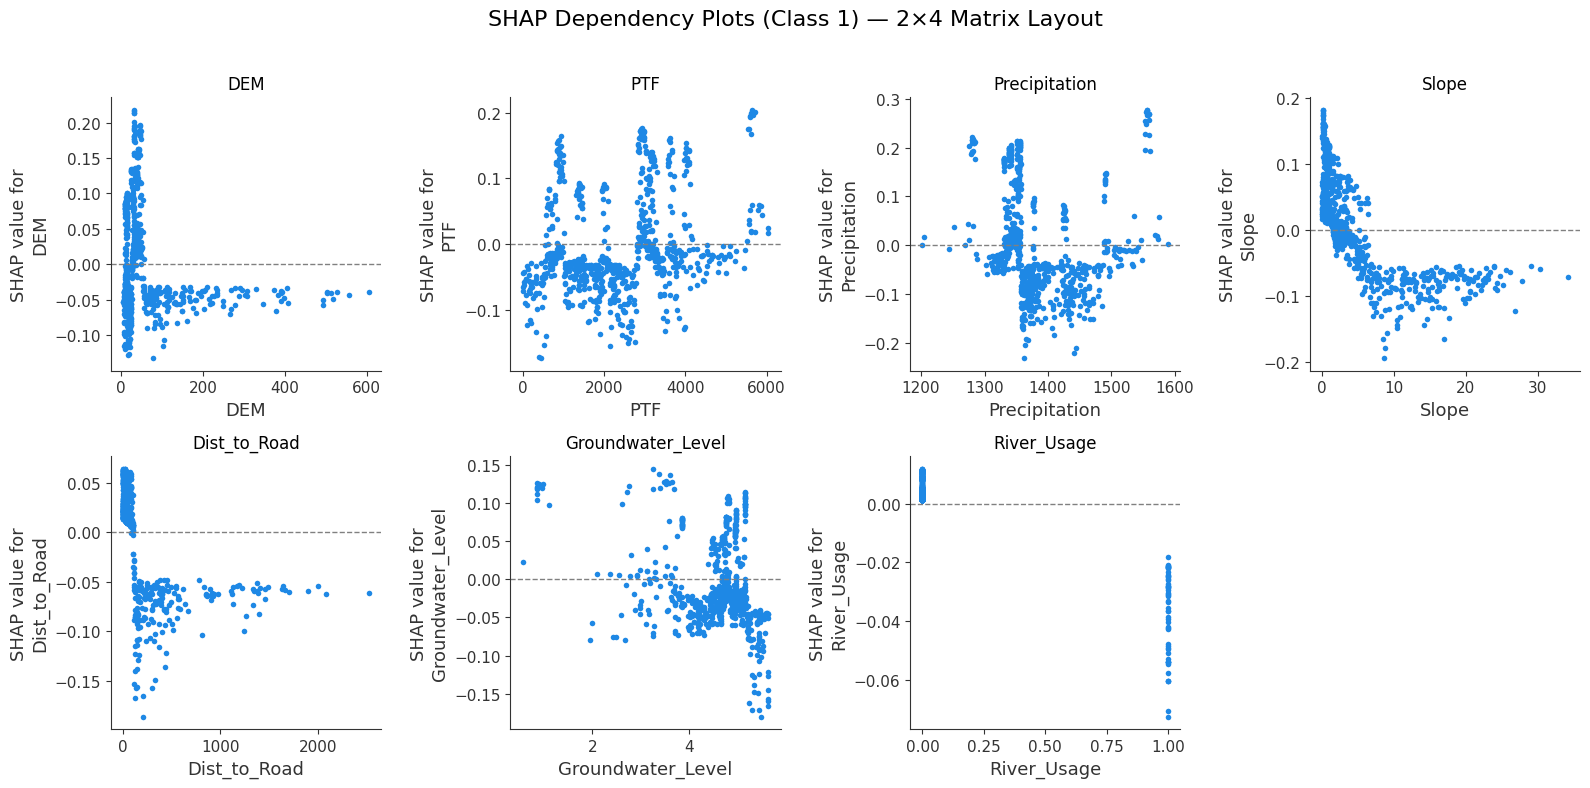

In [ ]:
# shap_vals_class1: (n_samples, 7) 형태의 클래스1 SHAP 값 배열
# X_test:          (n_samples, 7) DataFrame
features = X_test.columns.tolist()   # 7개 피처 리스트

# 1) 2행×4열 서브플롯 생성 (총 8칸)
n_rows, n_cols = 2, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8), sharex=False, sharey=False)
axes = axes.flatten()

# 2) 각 피처마다 dependency plot 그리기
for i, feat in enumerate(features):
    ax = axes[i]
    # shap.dependence_plot에 ax 파라미터 전달 (show=False로 plt 호출 제어)
    shap.dependence_plot(
        feat,
        shap_values_class1,
        X_test,
        interaction_index=None,
        ax=ax,
        show=False
    )
    # SHAP 값 0 기준 보조선 추가
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_title(feat)

# 3) 남은 축들은 비활성화
for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.suptitle("SHAP Dependency Plots (Class 1) — 2×4 Matrix Layout", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Susceptibility Map

['DEM', 'PTF', 'Precipitation', 'Slope', 'Dist_to_Road', 'Groundwater_Level', 'River_Usage']
<class 'geopandas.geodataframe.GeoDataFrame'>


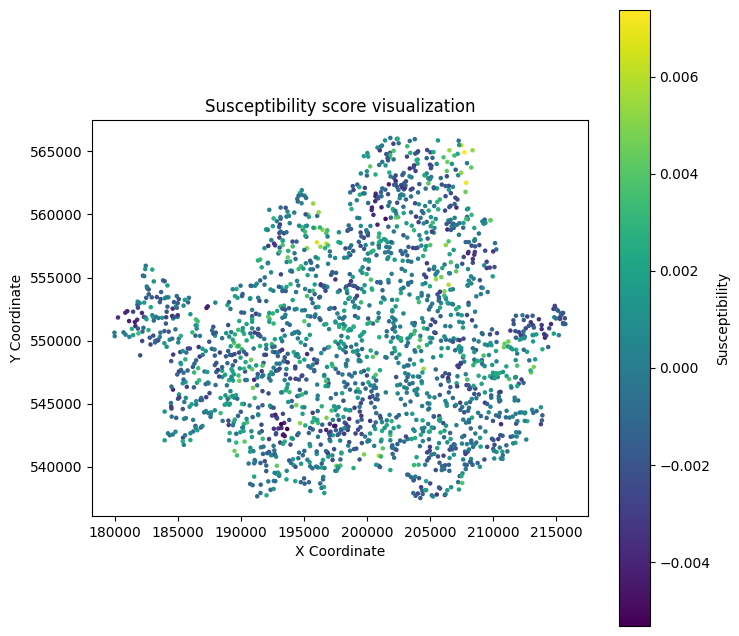

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shap

# — 0) 피처 리스트 —
feature_cols = gdf.columns[1:-3].tolist()
print(feature_cols)

# — 1) 2,000개 샘플 추출 (train/test에서 각각 1,000개씩) —
sample_idx = list(train_gdf.index[:1000]) + list(test_gdf.index[:1000])
X_sample = gdf.loc[sample_idx, feature_cols]

# — 2) 2,000개 샘플에 대해서만 SHAP 계산 (클래스1 기준) —
shap_vals = explainer.shap_values(X_sample)    # [class0, class1] 각각에 대해 SHAP value 제공
shap_sample_class1 = shap_vals[:,:,1]              # class 1에 대한 SHAP value만 취함. -> shape = (2000, 7)

# — 3) Global SHAP importance 계산 (평균 절대 SHAP) —
global_imp = np.mean(np.abs(shap_sample_class1), axis=0)  # (7,)

# — 4) 각 샘플별 Susceptibility = dot(global_imp, local_shap) —
suscept_sample = shap_sample_class1.dot(global_imp)      # (2000,)

# — 5) GeoDataFrame으로 변환 & 지수 할당 —
gdf_sample = gdf.loc[sample_idx].copy()
gdf_sample['suscept'] = suscept_sample
# 1) 타입 확인
print(type(gdf_sample))
# <class 'geopandas.geodataframe.GeoDataFrame'> 이어야 합니다.

# 6) 시각화
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(
    gdf_sample.geometry.x, gdf_sample.geometry.y,
    c=gdf_sample['suscept'],
    cmap='viridis',
    s=5,
    marker='o'
)
cbar = fig.colorbar(scatter, ax=ax, label='Susceptibility')
ax.set_title('Susceptibility score visualization')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_aspect('equal')
plt.show()

#5. 논문 프레임워크 정리

**1) LightGBM / XGBoosst / RandomForest**

논문에서 모델을 세개나 썼다길래 세 모델의 결과를 앙상블한 줄 알았는데, 각 모델의 결과를 비교분석하는 데에만 그쳤음. 모두 Optuna로 하이퍼파라미터 튜닝 가능한데, 모델별 특성이 상이하므로 이를 기반으로 개별 모델의 예측 설명해볼 것.


---

**2) Ensemble**

이거 논문에서 안쓰였긴 한데.. 그냥 혹시나 해서

- Soft Voting 방식

각 모델을 독립적으로 훈련 후, 테스트 시 세 모델의 클래스별 확률을 단순 평균 / 가중평균하여 최종 예측을 진행함. 가중치는 사전에 직접 지정해야하는 hyperparameter.


- Stacking 방식

각 모델을 독립적으로 훈련한 후, "validation dataset"에 대한 모델의 예측치 p1, p2, p3를 새로운 피쳐로 해서 logistic regression 분류기 학습. test에는 이 logistic regression 분류기의 예측 확률을 사용한다!

가중치가 learnable한 경우라고 생각하면 됨.



---

**3) SHAP**

SHAP는 특정 피쳐가 예측 확률에 기여하는 정도를 나타내는 수치로서, training 후 inference 과정에서 주로 활용됨.

Susceptibility map을 왜 계산해야 하는가?에 대해 납득하지 못했음.


수학적 정의는 '기댓값' 느낌인데, 특정 피처를 포함했을 때와 제외했을 때의 예측 차이를 모든 조합에 대해 평균한 값임. 그러나 트리 모델에 대해서는 이를 노가다로 계산하는게 빡쎄서 TreeExplainer라는 알고리즘을 사용해서 계산할 수 있다고 함. 딥하게 이해하는건 시간 나면 ㄱㄱ

논문에서는 성과가 가장 좋았던 Random Forest에 대해서만 SHAP를 분석하였으며, 활용 방법은 다음과 같음.


- SHAP local importance

각 피쳐에 대해 모든 샘플의 SHAP값을 찍어서 RF-SHAP Summary Plot을 그림 (Figure 8-a). 모든 샘플에 대해 피쳐별 SHAP값을 계산한 후, y축을 피쳐 / x축을 SHAP value로 정의해서 plotting한거임.

Susceptibility를 높일 경우 SHAP value가 +, 낮출 경우 SHAP value가 -이며, SHAP value의 변동이 클수록 모델 예측에 영향을 많이 주는 피쳐임. 따라서 가로로 길게 띠가 형성되며, 영향력이 높은 피쳐일 수록 위쪽에 배치함.


- SHAP global importance

"모델 예측에 얼마나 영향을 많이 주는가"를 정량적 수치로 환산하기 위해, 피쳐별로 SHAP의 절댓값 합을 계산해서 plotting함 (figure 8-b)

- SHAP Dependence Plot

각 피쳐별로, 샘플 i의 피쳐 j에 대한 SHAP를 구할 수 있었음. 이를 활용해서, 각 피쳐에 대해 (샘플의 피쳐 값, SHAP 값)을 뽑아서 scatterplot을 그림. local importance는 피쳐별로 샘플의 SHAP값 분포만 분석할 수 있었던 반면, SHAP Dependence Plot은 피쳐별로 (샘플의 피쳐 값, 샘플의 SHAP 값) 분포 joint하게 분석 가능.

이 때, SHAP 값이 양수로 전환되는 피쳐 값 구간을 뽑아낼 수 있음. SHAP 값이 양수로 전환된다는 것은, 예측 확률을 증가시킨다는것임 (변화율이 양수). 따라서 이 threshold는 취약도가 급증하는 구간으로 해석됨.

특정 scatter plot의 각 샘플에 대해, 그 샘플이 가지는 다른 피쳐의 값을 색상 형태로 찍을 경우 (샘플 피쳐 A값, 샘플 피쳐 B값, 샘플 피쳐 A에 대한 SHAP 값) 이런식으로 상호의존성 분석 가능.

- SHAP Susceptibility Plot

데이터셋의 각 지점이 곧 하나의 데이터 샘플이었음. 따라서, global shap importance 벡터와 샘플 별 shap value 벡터의 내적값을 지점별 susceptibility로 정의함.

그냥 모델의 예측 확률을 susceptibility 지수로 쓰는 상황이랑 비교했을 떄, SHAP를 활용하여 지수를 계산할 경우 "어느 피쳐가 위험도를 높였는지"에 대한 설명력이 존재한다고 함. 솔직히 납득은 안됨.




